In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import torchvision
from torch.utils import data
from torchvision import transforms
from time import time
import multiprocessing as mp

In [2]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 50

        self.conv1 = nn.Conv2d(3, 50, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(50)
        self.layer1 = self._make_layer(block, 50, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 100, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 200, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 400, num_blocks[3], stride=2)
        self.linear = nn.Linear(400, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project1_model():
    return ResNet(BasicBlock, [1, 2, 4, 1])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:
transform_train = torchvision.transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=256, shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=1000, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [4]:
net = project1_model()

num = count_parameters(net)
print(num)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

train_loss_list = []
train_acc_list = []
#train_dur_list = []
test_loss_list = []
test_acc_list = []
#test_dur_list = []

In [5]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    batch_index = 0
    t0 = time()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        # loss = nll(outputs, targets)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        batch_index = batch_idx
        # train_loss += loss.item()
        train_loss = loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        #print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     #% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        #print("\n")
    train_loss_list.append(train_loss/(batch_index+1))
    train_acc_list.append(100.*correct/total)
    print(' Train: Loss: %.6f | Acc: %.3f%% | Dur: %.2fS' 
          % (train_loss/(batch_index+1), 100.*correct/total, time() - t0))

def test(epoch):
#     global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    batch_index = 0
    t0 = time()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            # loss = nll(outputs, targets)
            batch_index = batch_idx
            # test_loss += loss.item()
            test_loss = loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            #print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         #% (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            #print("\n")
    test_loss_list.append(test_loss/(batch_index+1))
    test_acc_list.append(100.*correct/total)
    print(' Test:  Loss: %.6f | Acc: %.3f%% | Dur: %.2fS' 
          % (test_loss/(batch_index+1), 100.*correct/total, time() - t0))

    # Save checkpoint.
#     acc = 100.*correct/total
#     if acc > best_acc:
#         print('Saving..')
#         state = {
#             'net': net.state_dict(),
#             'acc': acc,
#             'epoch': epoch,
#             'train_history': (train_loss_list, train_acc_list, test_loss_list, test_acc_list)
#         }
#         if not os.path.isdir('checkpoint'):
#             os.mkdir('checkpoint')
#         torch.save(state, './checkpoint/ckpt_rmsprop.pth')
#         best_acc = acc


def plot_model(train_loss, train_acc, test_loss, test_acc):
    length = len(train_acc)
    plt.subplot(2, 2, 1)
    plt.plot(range(length), train_acc)
    plt.title('Train accuracy vs. epoches')
    plt.ylabel('Train accuracy')
    plt.xlabel('epoch')
    plt.subplot(2, 2, 2)
    plt.plot(range(length), train_loss)
    plt.title('Train loss vs. epoches')
    plt.ylabel('Train loss')
    plt.xlabel('epoch')
    plt.subplot(2, 2, 3)
    plt.plot(range(length), test_acc)
    plt.title('Test accuracy vs. epoches')
    plt.ylabel('Test accuracy')
    plt.xlabel('epoch')
    plt.subplot(2, 2, 4)
    plt.plot(range(length), test_loss)
    plt.title('Test loss vs. epoches')
    plt.ylabel('Test loss')
    plt.xlabel('epoch')

In [6]:
for epoch in range(100):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 0
 Train: Loss: 0.005646 | Acc: 45.484% | Dur: 20.48S
 Test:  Loss: 0.137226 | Acc: 53.880% | Dur: 2.54S

Epoch: 1
 Train: Loss: 0.003664 | Acc: 64.726% | Dur: 16.89S
 Test:  Loss: 0.092454 | Acc: 67.190% | Dur: 2.54S

Epoch: 2
 Train: Loss: 0.004196 | Acc: 72.830% | Dur: 16.93S
 Test:  Loss: 0.089377 | Acc: 71.110% | Dur: 2.56S

Epoch: 3
 Train: Loss: 0.003429 | Acc: 77.982% | Dur: 16.85S
 Test:  Loss: 0.089087 | Acc: 70.100% | Dur: 2.54S

Epoch: 4
 Train: Loss: 0.002696 | Acc: 81.170% | Dur: 16.84S
 Test:  Loss: 0.082324 | Acc: 73.140% | Dur: 2.51S

Epoch: 5
 Train: Loss: 0.001887 | Acc: 83.254% | Dur: 16.82S
 Test:  Loss: 0.048384 | Acc: 82.500% | Dur: 2.54S

Epoch: 6
 Train: Loss: 0.002227 | Acc: 85.208% | Dur: 16.81S
 Test:  Loss: 0.039970 | Acc: 83.760% | Dur: 2.56S

Epoch: 7
 Train: Loss: 0.002567 | Acc: 86.888% | Dur: 16.95S
 Test:  Loss: 0.050412 | Acc: 82.830% | Dur: 2.52S

Epoch: 8
 Train: Loss: 0.001611 | Acc: 88.004% | Dur: 16.90S
 Test:  Loss: 0.040857 | Acc: 84.7

 Train: Loss: 0.000349 | Acc: 98.078% | Dur: 17.65S
 Test:  Loss: 0.038167 | Acc: 90.030% | Dur: 2.56S

Epoch: 73
 Train: Loss: 0.000616 | Acc: 97.402% | Dur: 17.91S
 Test:  Loss: 0.036489 | Acc: 89.300% | Dur: 2.54S

Epoch: 74
 Train: Loss: 0.000773 | Acc: 96.922% | Dur: 17.69S
 Test:  Loss: 0.036221 | Acc: 88.910% | Dur: 2.54S

Epoch: 75
 Train: Loss: 0.000684 | Acc: 96.696% | Dur: 17.82S
 Test:  Loss: 0.038102 | Acc: 88.760% | Dur: 2.51S

Epoch: 76
 Train: Loss: 0.001436 | Acc: 96.506% | Dur: 17.58S
 Test:  Loss: 0.035455 | Acc: 89.060% | Dur: 2.55S

Epoch: 77
 Train: Loss: 0.000247 | Acc: 96.534% | Dur: 17.45S
 Test:  Loss: 0.051055 | Acc: 86.970% | Dur: 2.53S

Epoch: 78
 Train: Loss: 0.000365 | Acc: 97.102% | Dur: 17.73S
 Test:  Loss: 0.050951 | Acc: 87.830% | Dur: 2.57S

Epoch: 79
 Train: Loss: 0.000512 | Acc: 96.880% | Dur: 17.76S
 Test:  Loss: 0.041602 | Acc: 88.880% | Dur: 2.54S

Epoch: 80
 Train: Loss: 0.000548 | Acc: 97.020% | Dur: 17.78S
 Test:  Loss: 0.043862 | Acc: 87.610

In [8]:
print(train_acc_list)
print(train_loss_list)

[45.484, 64.726, 72.83, 77.982, 81.17, 83.254, 85.208, 86.888, 88.004, 89.27, 90.64, 91.388, 92.478, 93.158, 94.13, 94.78, 95.512, 95.7, 96.16, 96.228, 96.382, 96.242, 96.248, 96.054, 95.966, 95.666, 95.252, 94.848, 94.028, 93.85, 93.042, 92.8, 92.896, 92.704, 92.44, 92.73, 92.658, 93.18, 93.25, 93.716, 94.11, 94.514, 95.022, 95.5, 95.786, 96.306, 96.798, 97.154, 97.866, 98.31, 98.68, 99.048, 99.37, 99.472, 99.662, 99.726, 99.776, 99.81, 99.824, 99.836, 99.808, 99.83, 99.83, 99.82, 99.8, 99.812, 99.79, 99.786, 99.69, 99.546, 99.228, 98.756, 98.078, 97.402, 96.922, 96.696, 96.506, 96.534, 97.102, 96.88, 97.02, 97.038, 97.328, 97.84, 98.126, 98.572, 98.866, 99.1, 99.394, 99.576, 99.734, 99.832, 99.912, 99.904, 99.912, 99.95, 99.972, 99.968, 99.966, 99.968]
[0.005645908871475531, 0.0036640897089121292, 0.004196129891337181, 0.0034288450771448563, 0.0026958125586412393, 0.0018869276557649886, 0.0022273392093424896, 0.002566671493102093, 0.001610760786095444, 0.001988117792168442, 0.0017219

In [9]:
print(test_acc_list)
print(test_loss_list)

[53.88, 67.19, 71.11, 70.1, 73.14, 82.5, 83.76, 82.83, 84.79, 85.14, 86.0, 86.86, 87.78, 88.21, 89.3, 89.73, 90.02, 90.15, 90.41, 90.57, 90.48, 90.36, 90.49, 90.19, 89.95, 90.0, 89.39, 88.34, 86.86, 85.52, 86.84, 83.02, 87.62, 86.1, 85.45, 83.09, 88.02, 85.08, 86.71, 87.25, 88.35, 83.97, 86.51, 88.4, 88.95, 89.14, 89.73, 90.07, 90.42, 91.17, 91.45, 91.97, 91.77, 92.4, 92.41, 92.36, 92.46, 92.56, 92.49, 92.54, 92.59, 92.4, 92.5, 92.53, 92.49, 92.5, 92.61, 92.49, 91.98, 91.95, 90.96, 89.44, 90.03, 89.3, 88.91, 88.76, 89.06, 86.97, 87.83, 88.88, 87.61, 90.03, 88.75, 90.04, 89.64, 90.66, 90.88, 91.15, 92.08, 92.23, 92.33, 92.58, 92.75, 92.74, 92.92, 92.87, 92.99, 93.08, 93.01, 93.06]
[0.13722612857818603, 0.09245379567146302, 0.08937729001045228, 0.08908651471138, 0.08232351541519164, 0.04838445484638214, 0.039970037341117856, 0.05041159391403198, 0.040856781601905826, 0.04476054906845093, 0.03759812116622925, 0.03599212765693664, 0.03367791175842285, 0.03172427415847778, 0.029424017667770

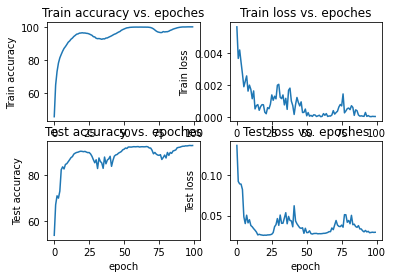

In [7]:
plot_model(train_loss_list,train_acc_list,test_loss_list,test_acc_list)

In [ ]:
model_path = './project1_model.pt'
torch.save(net.state_dict(), model_path)